In [1]:
import sys
import enum
from collections import defaultdict
from copy import deepcopy
from typing import Optional

import optuna
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from gym import spaces
from gym.envs.toy_text.blackjack import (
    BlackjackEnv, 
    cmp, 
    usable_ace, 
    sum_hand, 
    is_bust, 
    score, 
    is_natural,
)


plt.rcParams['figure.figsize'] = (10, 6)

env = gym.make('Blackjack-v1')
N_EPISODES = 500_000


Rewards:
- 0 - draw
- -1 - lose
- 1 - win

# Utils

In [2]:
def run_game_episode(env, policy, *args, **kwargs):
    states, actions, rewards = [], [], []
    (player_sum, dealer_card, usable_ace), _ = env.reset()
    while True:
        state = player_sum, dealer_card, usable_ace
        states.append(state)
        action = policy(env, state, *args, **kwargs)
        actions.append(action)
        (player_sum, dealer_card, usable_ace), reward, endgame, _, _ = env.step(action)
        rewards.append(reward)
        if endgame:
            break
    return states, actions, rewards


def run_game_episode_with_cards_cnt(env, policy, *args, **kwargs):
    states, actions, rewards = [], [], []
    (player_sum, dealer_card, usable_ace, cards_cnt), _ = env.reset()
    while True:
        state = player_sum, dealer_card, usable_ace, cards_cnt
        states.append(state)
        action = policy(env, state, *args, **kwargs)
        actions.append(action)
        (player_sum, dealer_card, usable_ace, cards_cnt), reward, endgame, _, _ = env.step(action)
        rewards.append(reward)
        if endgame:
            break
    return states, actions, rewards


def plot_avg_reward(rewards):
    avg_rewards = [cs / (i + 1) for i, cs in enumerate(np.cumsum(rewards))]
    plt.plot(avg_rewards)
    plt.xlabel('Game episode')
    plt.ylabel('Average reward')
    plt.show()

# Task 1
Рассмотрим очень простую стратегию: 
1. говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


## 1 Simple polisy

In [3]:
class Action:
    STAND = 0
    HIT = 1
    DOUBLE = 2

Average reward after 500000 games: -0.194154


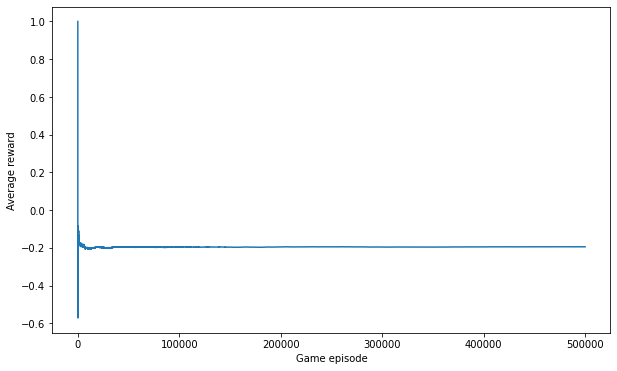

In [4]:
def simple_polisy(env, state):
    player_sum, dealer_card, usable_ace = state
    action = Action.HIT if player_sum < 19 else Action.STAND
    return action

# average_reward = np.mean([run_game_episode(env, simple_polisy)[-1][-1] for _ in tqdm(range(N))])
results = Parallel(n_jobs=-1)(delayed(run_game_episode)(env, simple_polisy) for _ in range(N_EPISODES))
rewards = [r[-1][-1] for r in results]
print(f"Average reward after {N_EPISODES} games: {np.mean(rewards)}")
plot_avg_reward(rewards)

## 1.2 Q-Learning

In [5]:
def get_probas(Q_s, eps, n_actions):
    policy_s = np.ones(n_actions) * eps / n_actions
    best_action_idx = np.argmax(Q_s)
    policy_s[best_action_idx] = 1 - eps + (eps / n_actions)
    return policy_s


def update_Q(env, states, actions, rewards, Q, alpha, gamma):
    for state, action, reward in zip(states, actions, rewards):
        first_occurence_idx = 0
        for i, s in enumerate(states):
            if s == state:
                first_occurence_idx = i
                break
        G = sum(
            [r * (gamma**i) for i, r in enumerate(rewards[first_occurence_idx:])]
        )
        Q[state][action] = Q[state][action] + alpha * (G - Q[state][action])
    return Q


def Q_policy(env, state, Q, eps, n_actions):
    probas = get_probas(Q[state], eps, n_actions)
    if state in Q:
        action = np.random.choice(np.arange(n_actions), p=probas)
    else:
        action = env.action_space.sample()
    return action


def qlearning(env, n_episodes, run_episode, eps=0.1, gamma=1.0, alpha=0.001):
    n_actions = env.action_space.n
    Q = defaultdict(lambda: np.zeros(n_actions))
    episodes_rewards = np.zeros(n_episodes)
    for i in (pbar := tqdm(range(n_episodes))): 
        if (i + 1) % 1000 == 0:       
            pbar.set_description(f"Average reward: {episodes_rewards[:i].mean():.6f}")
        states, actions, rewards = run_episode(env, Q_policy, Q=Q, eps=eps, n_actions=n_actions)
        episodes_rewards[i] = rewards[-1]
        Q = update_Q(env, states, actions, rewards, Q, alpha, gamma)
    
    return episodes_rewards

In [6]:
rewards = qlearning(env, N_EPISODES, run_game_episode, eps=0.1, gamma=1.0, alpha=0.001)

Average reward: -0.104900: 100%|██████████| 500000/500000 [00:38<00:00, 13054.09it/s]


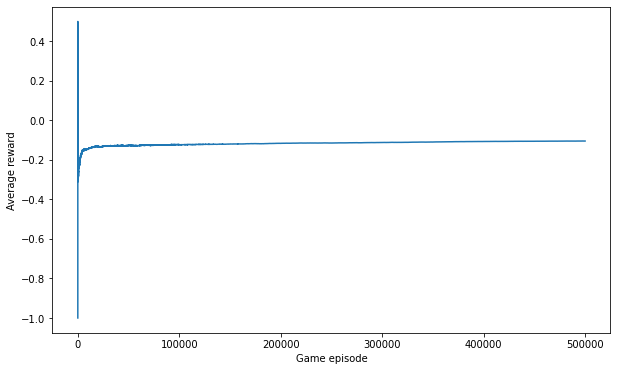

In [7]:
plot_avg_reward(rewards)

## 3 Hyperparameters optimization

In [8]:
def objective(trial):
    eps = trial.suggest_float("eps", 1e-3, 0.3)
    gamma = trial.suggest_float("gamma", 0.1, 1.1)
    alpha = trial.suggest_float("alpha", 1e-5, 0.9)

    rewards = qlearning(env, 100_000, run_game_episode, eps=eps, gamma=gamma, alpha=alpha)
    return -np.mean(rewards)

opt_study = optuna.create_study()
opt_study.optimize(objective, n_trials=10)

opt_study.best_params

[I 2022-10-26 14:02:55,115] A new study created in memory with name: no-name-a28dfd5a-cece-4794-bf0d-02b9da041282
Average reward: -0.185122: 100%|██████████| 100000/100000 [00:07<00:00, 12892.65it/s]
[I 2022-10-26 14:03:02,876] Trial 0 finished with value: 0.18513 and parameters: {'eps': 0.2558530665417874, 'gamma': 0.5917791314209766, 'alpha': 0.639971983536858}. Best is trial 0 with value: 0.18513.
Average reward: -0.179782: 100%|██████████| 100000/100000 [00:07<00:00, 13042.20it/s]
[I 2022-10-26 14:03:10,545] Trial 1 finished with value: 0.17979 and parameters: {'eps': 0.28234260328012367, 'gamma': 0.7319395667115997, 'alpha': 0.4808401261466603}. Best is trial 1 with value: 0.17979.
Average reward: -0.105361: 100%|██████████| 100000/100000 [00:08<00:00, 12429.01it/s]
[I 2022-10-26 14:03:18,593] Trial 2 finished with value: 0.10537 and parameters: {'eps': 0.06617691313194644, 'gamma': 0.9270680236594832, 'alpha': 0.5382151835790357}. Best is trial 2 with value: 0.10537.
Average rewa

{'eps': 0.06084302792763172,
 'gamma': 0.8715145246490869,
 'alpha': 0.0476161716269745}

In [9]:
best_params = {
    'eps': 0.01892594518639367,
    'gamma': 0.5005643028229018,
    'alpha': 0.013700199111808453
 } # = opt_study.best_params.values()
rewards = qlearning(env, N_EPISODES, run_game_episode, **best_params)

Average reward: -0.058580: 100%|██████████| 500000/500000 [00:39<00:00, 12654.13it/s]


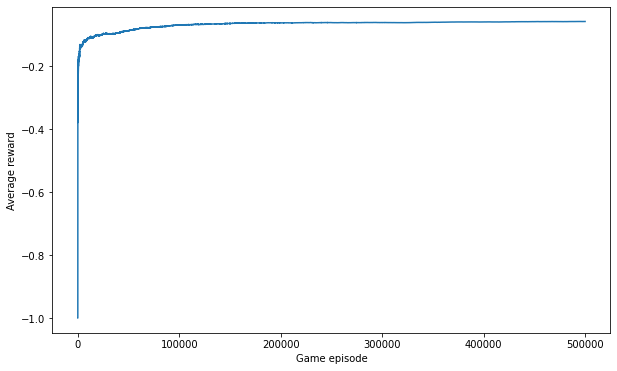

In [10]:
plot_avg_reward(rewards)

Не получилось даже выйти в 0

# Task2
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


## 4 BlackJack with double bet

In [11]:
class DoubleBetBlackJack:
    def __init__(self, env) -> None:
        self.env = deepcopy(env)
        self.env.action_space = spaces.Discrete(3)
        self.action_space = self.env.action_space

    def reset(self):
        return self.env.reset()

    def step(self, action):
        if action == Action.DOUBLE:
            (player_sum, dealer_card, usable_ace), reward, endgame, info1, info2 = self.env.step(Action.HIT)
            while not endgame:
                (player_sum, dealer_card, usable_ace), reward, endgame, info1, info2 = self.env.step(Action.STAND)
            return (player_sum, dealer_card, usable_ace), reward * 2, endgame, info1, info2
        return self.env.step(action)

In [12]:
env2 = DoubleBetBlackJack(env)

## 5 Q-Learning with double bet blackjack

Average reward: -0.054954: 100%|██████████| 1000000/1000000 [01:20<00:00, 12486.29it/s]


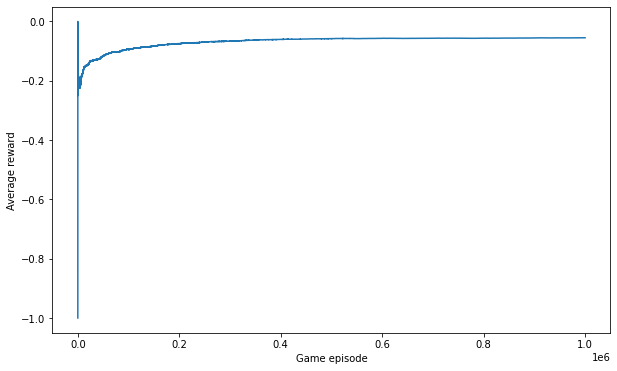

In [14]:
N_EPISODES = 1_000_000

best_params = {
    'eps': 0.01892594518639367,
    'gamma': 0.5005643028229018,
    'alpha': 0.013700199111808453
 }
rewards = qlearning(env2, N_EPISODES, run_game_episode, **best_params)
plot_avg_reward(rewards)

In [15]:
def objective(trial):
    eps = trial.suggest_float("eps", 1e-3, 0.3)
    gamma = trial.suggest_float("gamma", 0.1, 1.1)
    alpha = trial.suggest_float("alpha", 1e-5, 0.9)

    rewards = qlearning(env, 500_000, run_game_episode, eps=eps, gamma=gamma, alpha=alpha)
    return -np.mean(rewards)

opt_study = optuna.create_study()
opt_study.optimize(objective, n_trials=10)

opt_study.best_params

[I 2022-10-26 14:20:46,768] A new study created in memory with name: no-name-3460cb40-71b4-47ef-977a-569632232519
Average reward: -0.154260: 100%|██████████| 500000/500000 [00:39<00:00, 12699.11it/s]
[I 2022-10-26 14:21:26,146] Trial 0 finished with value: 0.154262 and parameters: {'eps': 0.16417213900952593, 'gamma': 0.426327848431709, 'alpha': 0.6774860907224332}. Best is trial 0 with value: 0.154262.
Average reward: -0.089790: 100%|██████████| 500000/500000 [00:39<00:00, 12797.38it/s]
[I 2022-10-26 14:22:05,218] Trial 1 finished with value: 0.089792 and parameters: {'eps': 0.03462626584460865, 'gamma': 0.9525510357617467, 'alpha': 0.448477831101232}. Best is trial 1 with value: 0.089792.
Average reward: -0.174366: 100%|██████████| 500000/500000 [00:38<00:00, 13076.99it/s]
[I 2022-10-26 14:22:43,456] Trial 2 finished with value: 0.174364 and parameters: {'eps': 0.28455454201375785, 'gamma': 0.46867683717836817, 'alpha': 0.26784470600361376}. Best is trial 1 with value: 0.089792.
Aver

{'eps': 0.04998396165066528,
 'gamma': 0.6583777552081488,
 'alpha': 0.10037755486139636}

Average reward: -0.056784: 100%|██████████| 1000000/1000000 [01:17<00:00, 12841.29it/s]


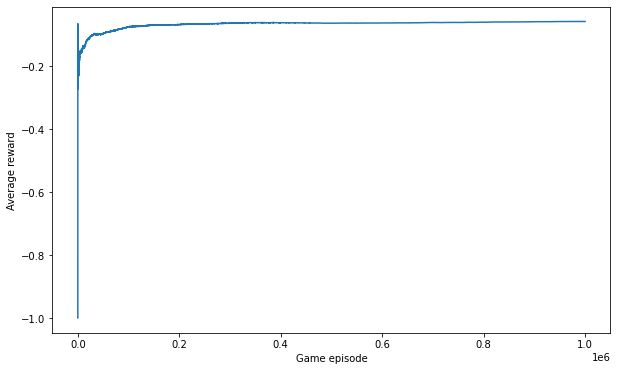

In [16]:
best_params = {
    'eps': 0.008519110047084291,
    'gamma': 0.8429176340858354,
    'alpha': 0.040646866183075184
 }
rewards = qlearning(env2, N_EPISODES, run_game_episode, **best_params)
plot_avg_reward(rewards)

# Task 3
6. Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [17]:
def init_deck():
    deck_count = {
        i: 4 for i in range(1, 10)
    }
    deck_count.update({10: 16})
    return deck_count


class BlackjackWithCardsCount(BlackjackEnv):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(3)
        self.deck_count = init_deck()
        self.deck_limit = 15
        self.deck_scores = {i: 1 for i in range(2, 7)}
        self.deck_scores.update({i: 0 for i in range(7, 10)})
        self.deck_scores.update({10: -1, 1: -1})
        self.counter = 0

    def reset_deck(self):
        if sum(self.deck_count.values()) < self.deck_limit:
            self.deck_count = init_deck()
            self.counter = 0

    def draw_card(self):
        self.reset_deck()
        deck_cnt = {card: cnt for card, cnt in self.deck_count.items() if cnt > 0}
        counts = list(deck_cnt.values())
        cards = list(deck_cnt.keys())
        probs = [count_ / sum(counts) for count_ in counts]
        card = np.random.choice(cards, p=probs)
        self.deck_count[card] -= 1
        self.counter += self.deck_scores[card]
        return card

    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.counter)

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            current_card = self.draw_card()
            self.deck_count[current_card] -= 1
            self.player.append(current_card)
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            if action == 2:
                current_card = self.draw_card()
                self.deck_count[current_card] -= 1
                self.player.append(current_card)
            terminated = True
            while sum_hand(self.dealer) < 17:
                current_card = self.draw_card()
                self.deck_count[current_card] -= 1
                self.dealer.append(current_card)
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
            
            if action == 2:
                reward *= 2

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, self.deck_count

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None, ):
        # reset deck
        self.reset_deck()
        
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()

        _, dealer_card_value, _, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), self.deck_count

In [18]:
env3 = BlackjackWithCardsCount()

Система "Плюс-Минус"
|Карты          |Числовые значения|
|---------------|-----------------|
|2, 3, 4, 5, 6	|+1               |
|7, 8, 9	    |0                |
|10, В, Д, К, Т	|−1               |

Average reward: -0.070645: 100%|██████████| 1000000/1000000 [01:53<00:00, 8788.16it/s]


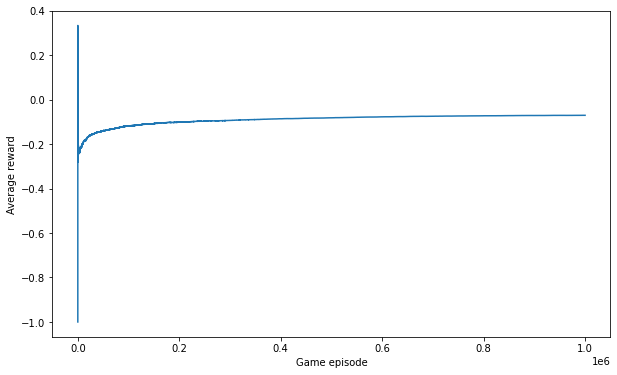

In [19]:
best_params = {
    'eps': 0.008519110047084291,
    'gamma': 0.8429176340858354,
    'alpha': 0.040646866183075184
 }
rewards = qlearning(env3, N_EPISODES, run_game_episode_with_cards_cnt, **best_params)
plot_avg_reward(rewards)

In [20]:
def objective(trial):
    eps = trial.suggest_float("eps", 1e-3, 0.3)
    gamma = trial.suggest_float("gamma", 0.1, 1.1)
    alpha = trial.suggest_float("alpha", 1e-5, 0.9)

    rewards = qlearning(env3, 500_000, run_game_episode_with_cards_cnt, eps=eps, gamma=gamma, alpha=alpha)
    return -np.mean(rewards)

opt_study = optuna.create_study()
opt_study.optimize(objective, n_trials=10)
best_params = opt_study.best_params
best_params

[I 2022-10-26 14:30:26,395] A new study created in memory with name: no-name-01208609-9c1a-4d0e-b0f0-4862be58bb88
Average reward: -0.132680: 100%|██████████| 500000/500000 [00:56<00:00, 8774.03it/s]
[I 2022-10-26 14:31:23,386] Trial 0 finished with value: 0.132682 and parameters: {'eps': 0.10762593946241249, 'gamma': 0.778678232971899, 'alpha': 0.2385411512905142}. Best is trial 0 with value: 0.132682.
Average reward: -0.209318: 100%|██████████| 500000/500000 [00:57<00:00, 8697.19it/s]
[I 2022-10-26 14:32:20,879] Trial 1 finished with value: 0.20932 and parameters: {'eps': 0.29082047219671264, 'gamma': 0.4892167700971789, 'alpha': 0.2436244801457434}. Best is trial 0 with value: 0.132682.
Average reward: -0.166778: 100%|██████████| 500000/500000 [00:57<00:00, 8717.12it/s]
[I 2022-10-26 14:33:18,240] Trial 2 finished with value: 0.16678 and parameters: {'eps': 0.12988842940771617, 'gamma': 0.9622920975617844, 'alpha': 0.7924117963557832}. Best is trial 0 with value: 0.132682.
Average re

{'eps': 0.03971210456817924,
 'gamma': 0.221015078917195,
 'alpha': 0.02269039108155716}

Average reward: -0.075216: 100%|██████████| 1000000/1000000 [08:23<00:00, 1984.25it/s]


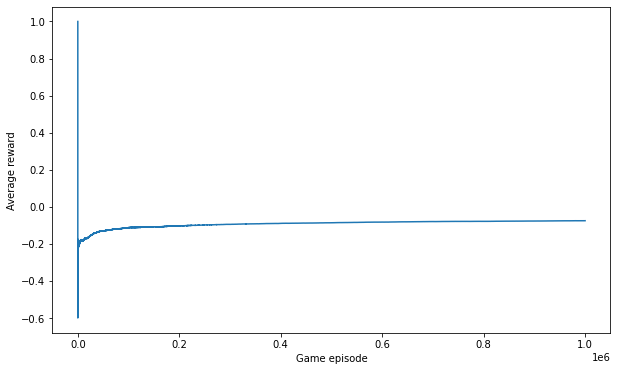

In [21]:
rewards = qlearning(env3, N_EPISODES, run_game_episode_with_cards_cnt, **best_params)
plot_avg_reward(rewards)